In [134]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# K-Means Clustering: A Larger Example

Now that we understand the k-means clustering algorithm, let's try an example with more features and use cross-validation to choose k. We will also show how you can (and should!) run the algorithm multiple times with different initial centroids because, as we saw in the animations from the previous section, the initialization can have an effect on the final clustering.

## Clustering Countries

For this example, we will use a dataset[^*] with information about countries across the world. It includes demographic, economic, environmental, and socio-economic information from 2023. This data and more information about it can be found [here](https://doi.org/10.34740/KAGGLE/DSV/6101670). The first few lines are shown below.

In [135]:
countries = pd.read_csv("../../data/world-data-2023.csv")
countries.head()

,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626
3,Andorra,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,469,...,36.40%,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801
4,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,"34,693",...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887


We want to see if we can cluster countries based on their characteristics. First, we need to do some cleaning. I don't want to include `Abbreviation`, `Calling Code`, `Capital/Major City`, `Largest city`, `Latitude`, or `Longitude` in my analysis because they uniquely identify a given country. I also see some variables that are numeric with percentage signs, dollar signs, and commas. These are characters which indicate that the variable is a string, but I would like them to be floats instead so that Python knows they have a numerical meaning.

The code used for this cleaning is hidden for brevity, but the resulting, clean dataframe is shown below.

In [136]:
countries_clean = countries.drop(columns = ['Abbreviation', 'Calling Code', 'Capital/Major City', 'Largest city', 'Latitude', 'Longitude','Minimum wage'])

def str_to_num(my_input):
    '''Takes in a number in string format and removes commas 
    and percentage signs before returning it as a float or int
    
    If the string is not a number or input is not a string, 
    returns the input'''


    if type(my_input) is str:

        cleaned_input = my_input.strip() #strip trailing whitespace
        cleaned_input = cleaned_input.removeprefix("$").removesuffix("%") #remove these characters if they are present
        
        if cleaned_input.isdigit():
            return int(cleaned_input)
        elif ("." in cleaned_input) and (cleaned_input.replace(".","").replace("-","").isdigit()): #is the only non-digit character a "."
            return float(cleaned_input)
        elif ("," in cleaned_input) and (cleaned_input.replace(",","").replace("-","").isdigit()): #is the only non-digit character a ","
            return int(cleaned_input.replace(",",""))
        elif ("." in cleaned_input) and ("," in cleaned_input) and (cleaned_input.replace(".","").replace(",","").replace("-","").isdigit()): #contains 2 non-digit characters "," and "."
            return float(cleaned_input.replace(",",""))
        else:
            return my_input
    else:
        return my_input
    
countries_clean = countries_clean.map(str_to_num) #apply this function to every cell in the dataframe
countries_clean = countries_clean.dropna(subset=countries_clean.columns.difference(['Official language','Currency code']),ignore_index = True) #remove rows with any missing numeric values
countries_clean.head()

,Country,Density\n(P/Km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Currency-Code,...,Maternal mortality ratio,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population
0,Afghanistan,60,58.1,652230.0,323000.0,32.49,8672.0,149.90,2.3,AFN,...,638.0,Pashto,78.4,0.28,38041754.0,48.9,9.3,71.4,11.12,9797273.0
1,Albania,105,43.1,28748.0,9000.0,11.78,4536.0,119.05,1.4,ALL,...,15.0,Albanian,56.9,1.20,2854191.0,55.7,18.6,36.6,12.33,1747593.0
2,Algeria,18,17.4,2381741.0,317000.0,24.28,150006.0,151.36,2.0,DZD,...,112.0,Arabic,28.1,1.72,43053054.0,41.2,37.2,66.1,11.70,31510100.0
3,Angola,26,47.5,1246700.0,117000.0,40.73,34693.0,261.73,17.1,AOA,...,241.0,Portuguese,33.4,0.21,31825295.0,77.5,9.2,49.1,6.89,21061025.0
4,Argentina,17,54.3,2780400.0,105000.0,17.02,201348.0,232.75,53.5,ARS,...,39.0,Spanish,17.6,3.96,44938712.0,61.3,10.1,106.3,9.79,41339571.0


### Using `sklearn`

In the previous section, we wrote our own functions to implement the k-means algorithm. This is a useful exercise to make sure we understand how the algorithm works, but there are libraries with optimized functions built to do these kinds of common analyses. The library `sklearn` is a popular machine learning library and has built in functions to do k-means clustering that are much faster than the functions we wrote. It is useful to know how to use these functions as well. First, you may need to install `sklearn`.

Before, we can cluster the data, we need to do some preprocessing. In the past, we have used our own functions to standardize and dummycode variables, but here we will show how to use functions from `pandas` and `sklearn`. First, we will need to import a functions from `sklearn.preprocessing`.

In [137]:
from sklearn.preprocessing import StandardScaler

In [138]:
country_names = countries_clean['Country']
num_columns = countries_clean.drop(columns=['Country', 'Currency-Code', 'Official language'])
cat_columns = countries_clean[['Currency-Code', 'Official language']]

In [139]:
cat_dummies = pd.get_dummies(cat_columns,drop_first=True,dummy_na=True)

In [140]:
scaler = StandardScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(num_columns),columns=num_columns.columns)

In [141]:
countries_proc = pd.concat([num_scaled,cat_dummies], axis = 1)
countries_proc.head()

,Density\n(P/Km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),...,Official language_Swahili,Official language_Swedish,Official language_Tamil,Official language_Thai,Official language_Tok Pisin,Official language_Turkish,Official language_Ukrainian,Official language_Urdu,Official language_Vietnamese,Official language_nan
0,-0.215644,0.818138,-0.115866,0.348798,1.264388,-0.232539,-0.077214,-0.280488,1.414957,-1.256779,...,False,False,False,False,False,False,False,False,False,False
1,-0.156441,0.115295,-0.389922,-0.417215,-0.788460,-0.236728,-0.335232,-0.389776,-0.774075,-0.051855,...,False,False,False,False,False,False,False,False,False,False
2,-0.270901,-1.088910,0.644351,0.334160,0.450584,-0.089375,-0.065003,-0.316917,0.301239,-1.317025,...,False,False,False,False,False,False,False,False,False,False
3,-0.260376,0.321462,0.145437,-0.153746,2.081166,-0.206181,0.858093,1.516694,2.221443,0.791591,...,False,False,False,False,False,False,False,False,False,False
4,-0.272217,0.640084,0.819584,-0.183020,-0.269053,-0.037369,0.615715,5.936791,-0.282503,-0.899936,...,False,False,False,False,False,False,False,False,False,False


 and then import the `KMeans` function from `sklearn.cluster`.

In [143]:
from sklearn.cluster import KMeans

The `KMeans` function takes in the number of clusters, k, as `n_clusters`, the number of times the algorithm should be run with different initial centroids as `n_init`, and a random seed (as explained in [Section 10.3](../../10/3/sampling.ipynb)) as `random_state`. It also takes in a maximum number of iterations and a tolerance as `max_iter` with default 300 and `tol` with default $10^{-4}$ respectively. For more information about the function, see the `scikit-learn` documentation ![[here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)].

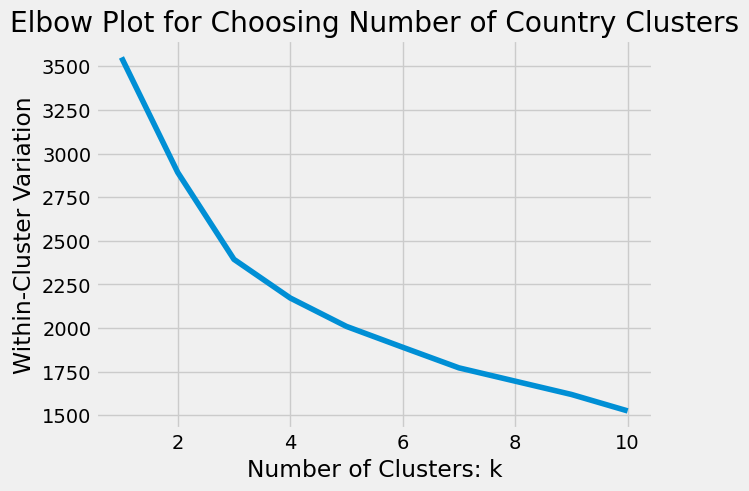

In [144]:
sse = []
for k in range(1, 11):
   kmeans = KMeans(n_clusters=k, n_init=10)
   kmeans.fit(countries_proc)
   sse.append(kmeans.inertia_)

plt.plot(range(1, 11),sse)
plt.xlabel("Number of Clusters: k")
plt.ylabel("Within-Cluster Variation")
plt.title('Elbow Plot for Choosing Number of Country Clusters');

The elbow of this plot looks to be around k = 4. So we will choose 4 clusters for our data.

In [151]:
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(countries_proc)

kmeans.labels_

array([2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1,
       2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2],
      dtype=int32)

In [146]:
country_names[kmeans.labels_ == 0]

0                           Afghanistan
3                                Angola
14                                Benin
18                         Burkina Faso
19                              Burundi
20                          Ivory Coast
22                             Cameroon
27                Republic of the Congo
32     Democratic Republic of the Congo
37                             Ethiopia
41                                Gabon
42                           The Gambia
45                                Ghana
48                               Guinea
62                                Kenya
65                                 Laos
70                           Madagascar
71                               Malawi
73                                 Mali
80                           Mozambique
85                                Niger
86                              Nigeria
90                     Papua New Guinea
99                               Rwanda
101                             Senegal


In [147]:
country_names[kmeans.labels_ == 1]

1                  Albania
6                Australia
7                  Austria
11                Barbados
12                 Belgium
13                  Belize
17                Bulgaria
23                  Canada
24                   Chile
28              Costa Rica
29                 Croatia
30                  Cyprus
31          Czech Republic
33                 Denmark
36                 Estonia
39                 Finland
40                  France
43                 Georgia
44                 Germany
46                  Greece
50                 Hungary
51                 Iceland
56     Republic of Ireland
57                  Israel
58                   Italy
59                 Jamaica
66                  Latvia
68               Lithuania
69              Luxembourg
74                   Malta
75               Mauritius
83             New Zealand
87                  Norway
94                  Poland
95                Portugal
97                 Romania
102                 Serbia
1

In [148]:
country_names[kmeans.labels_ == 2]

2                   Algeria
4                 Argentina
5                   Armenia
8                Azerbaijan
9                   Bahrain
10               Bangladesh
15                 Botswana
16                   Brazil
21               Cape Verde
26                 Colombia
34       Dominican Republic
35                    Egypt
38                     Fiji
47                Guatemala
49                 Honduras
53                Indonesia
54                     Iran
55                     Iraq
60                   Jordan
61               Kazakhstan
63                   Kuwait
64               Kyrgyzstan
67                  Lebanon
72                 Malaysia
76                   Mexico
77                  Moldova
78                 Mongolia
79                  Morocco
81                  Myanmar
82                    Nepal
84                Nicaragua
88                     Oman
89                 Pakistan
91                 Paraguay
92                     Peru
93              Phil

In [149]:
country_names[kmeans.labels_ == 3]

25             China
52             India
128    United States
Name: Country, dtype: object

In [152]:
import plotly.express as px

dat = pd.DataFrame({'country_names': country_names, 'cluster': np.array([str(lab) for lab in kmeans.labels_])})

fig = px.choropleth(dat, locations="country_names",
                    locationmode='country names',
                    color="cluster", 
                    hover_name="country_names",
                    category_orders={"cluster":["0","1","2","3"]})
fig.update_layout(legend_title_text='Cluster')

fig.show()

## Disadvantages of `K-Means` Clustering

As we discussed previously, k-means clustering has several disadvantages. It does not always converge to a solution that provides the global minimum within-cluster variability. Because of this, it can also give differing solutions depending on the initial starting points. In addition, the k-means algorithm requires the user to specify the number of clusters, which may not always be obvious, especially for data with high dimensionality. In the next section, we will discuss another clustering method that does not require you to specify a number of clusters: hierarchical clustering.

[^*]: Nidula Elgiriyewithana. (2023). Global Country Information Dataset 2023 [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/6101670